# Analyzing Political Speeches

Public speeches are interesting. Its history supposedly traces back to [ancient Athens](https://virtualspeech.com/blog/history-public-speaking#:~:text=The%20study%20of%20public%20speaking,lawyers%20for%20the%20average%20Athenian), where men were required to give speeches as part of their civic duties. 

In this project, I will be quantitatively analyzing the State of the Union speeches of U.S. presidents. 

For the uninitiated, the U.S. president's State of the Union Address is an annual speech delivered by the president at the start of each calendar year, and includes reports on the nation's budget, economy, and things on the president's agenda for the coming year. The State of the Union speeches are politically significant and receive millions of views -- Obama's State of the Union speeches averaged about 38.8 million viewers each year. Trump's first State of the Union speech was watched by 45.5 million viewers in 2018. 

Some State of the Union speeches are more memorable than others. Who can forget George W. Bush's 'axis of evil'-- a phrase that would later characterise international relations? 

For this reason, these speeches are worth further analyses. Some researchers use critical discourse analysis to examine the language used, as well as the social and political contexts in which they occur. For this project I'll be performing a textual and sentiment analysis of the State of the Union speeches performed by Donald Trump and Barack Obama.

# Importing Libraries

These are the libraries I'll be working with for this project:

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import readability
from readability import Readability
import nltk
from nltk.tokenize import word_tokenize
nltk.download('universal_tagset')
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

/Users/rachyl/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/rachyl/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


# Data Collection and Preparation

For this project, I have manually collected Obama and Trump's speeches from 2010 to 2020 and saving them as .txt files in the 'all_speeches' folder in the current directory. The faster way would definitely 
be to scrape them via the Beautiful Soup library, but I'll be demonstrating my web scraping skills in a separate project later.

## Creating a Dataframe to Store All Speeches

In [57]:
# first, use the glob library to create a list of file names that ends with .txt

files = glob.glob('all_speeches/*.txt')
files

['all_speeches/obama2016.txt',
 'all_speeches/obama2015.txt',
 'all_speeches/trump2019.txt',
 'all_speeches/trump2018.txt',
 'all_speeches/obama2014.txt',
 'all_speeches/obama2010.txt',
 'all_speeches/trump2020.txt',
 'all_speeches/obama2011.txt',
 'all_speeches/obama2013.txt',
 'all_speeches/obama2012.txt']

In [58]:
# getting a list of strings containing the speeches

lst = []
for file in files:
    with open(file, 'r') as f:
        text = f.read()
        text.strip()
        lst.append(text)

lst

['Mr. Speaker, Mr. Vice President, Members of Congress, my fellow Americans:\n\nTonight marks the eighth year I\'ve come here to report on the State of the Union. And for this final one, I\'m going to try to make it shorter. I know some of you are antsy to get back to Iowa.\n\nI also understand that because it\'s an election season, expectations for what we\'ll achieve this year are low. Still, Mr. Speaker, I appreciate the constructive approach you and the other leaders took at the end of last year to pass a budget and make tax cuts permanent for working families. So I hope we can work together this year on bipartisan priorities like criminal justice reform, and helping people who are battling prescription drug abuse. We just might surprise the cynics again.\n\nBut tonight, I want to go easy on the traditional list of proposals for the year ahead. Don\'t worry, I\'ve got plenty, from helping students learn to write computer code to personalizing medical treatments for patients. And I\

In [59]:
# creating a list of names

names = []
for file in files:
    names.append(file[13:18])

names

['obama',
 'obama',
 'trump',
 'trump',
 'obama',
 'obama',
 'trump',
 'obama',
 'obama',
 'obama']

In [60]:
# creating a list of years

years = []
for file in files:
    years.append(file[18:22])
    
years

['2016',
 '2015',
 '2019',
 '2018',
 '2014',
 '2010',
 '2020',
 '2011',
 '2013',
 '2012']

In [61]:
# creating a dictionary with the lists above
dic = {'filename': files, 'name': names, 'year': years, 'speech': lst} 

# creating a DataFrame to work with 
df = pd.DataFrame(dic)

#printing df
df

,filename,name,year,speech
0,all_speeches/obama2016.txt,obama,2016,"Mr. Speaker, Mr. Vice President, Members of Co..."
1,all_speeches/obama2015.txt,obama,2015,"Mr. Speaker, Mr. Vice President, Members of Co..."
2,all_speeches/trump2019.txt,trump,2019,"Madam Speaker, Mr. Vice President, Members of ..."
3,all_speeches/trump2018.txt,trump,2018,"Mr. Speaker, Mr. Vice President, Members of Co..."
4,all_speeches/obama2014.txt,obama,2014,"Mr. Speaker, Mr. Vice President, Members of Co..."
5,all_speeches/obama2010.txt,obama,2010,"Madam Speaker, Vice President Biden, members o..."
6,all_speeches/trump2020.txt,trump,2020,Thank you very much. Thank you. Thank you v...
7,all_speeches/obama2011.txt,obama,2011,"Mr. Speaker, Mr. Vice President, members of Co..."
8,all_speeches/obama2013.txt,obama,2013,"Mr. Speaker, Mr. Vice President, members of Co..."
9,all_speeches/obama2012.txt,obama,2012,"Mr. Speaker, Mr. Vice President, members of C..."


# Quantifying Speeches

Speeches, like all long-form documents, can be quantified and analyzed. Quantifying differences allow us to objectively analyze the readability and effectiveness of the speech, and I'll be using the following methods. 

## Readability

### The "Simple Measure of Gobbledygook" (SMOG) Score

This estimates the years of education needed to understand a piece of writing, and does so by counting the percentage of words with there or more syllables. It's considered to be a [rigorous](https://cdn1.sph.harvard.edu/wp-content/uploads/sites/135/2012/09/smogoverview.pdf) reading assessment tool because it focuses on the length of words and sentences, rather than just words alone.

### The Flesch Reading-Ease Test 

Like the SMOG score, the Flesch Reading-Ease test also gauges the level of education required to read a body of text, but does so by counting the average sentence length and average syllables per word. It weights long words more than long sentences. 

In general, while speeches that have a lower SMOG score  or a higher Flesch Reading-East score may be interpreted as "too simple" or "not intellectual enough", it is actually not a negative point, insofar as State of the Union addresses are widely watched by the general population. 

In [63]:
# Step 8: Add SMOGIndex and FleschReadingEase

smog = []
flesch = []

for value in df['speech'].values:
    smog.append(Readability(value).smog().score)
    flesch.append(Readability(value).flesch().score)
    
df['SMOG_index'] = smog
df['Flesch_score'] = flesch

df

,filename,name,year,speech,len_speech,sentences,num_sentences,average_sen_length,SMOG_index,Flesch_score
0,all_speeches/obama2016.txt,obama,2016,"Mr. Speaker, Mr. Vice President, Members of Co...",31167,"[Mr, Speaker, Mr, Vice President, Members of...",295,105.650847,10.203070,62.014665
1,all_speeches/obama2015.txt,obama,2015,"Mr. Speaker, Mr. Vice President, Members of Co...",40269,"[Mr, Speaker, Mr, Vice President, Members of...",458,87.923581,10.125757,66.451759
2,all_speeches/trump2019.txt,trump,2019,"Madam Speaker, Mr. Vice President, Members of ...",30945,"[Madam Speaker, Mr, Vice President, Members o...",295,104.898305,12.968742,55.642559
3,all_speeches/trump2018.txt,trump,2018,"Mr. Speaker, Mr. Vice President, Members of Co...",30457,"[Mr, Speaker, Mr, Vice President, Members of...",322,94.586957,11.140535,58.501715
4,all_speeches/obama2014.txt,obama,2014,"Mr. Speaker, Mr. Vice President, Members of Co...",40009,"[Mr, Speaker, Mr, Vice President, Members of...",352,113.661932,11.855464,58.464553
5,all_speeches/obama2010.txt,obama,2010,"Madam Speaker, Vice President Biden, members o...",43698,"[Madam Speaker, Vice President Biden, members ...",558,78.311828,10.125757,65.128535
6,all_speeches/trump2020.txt,trump,2020,Thank you very much. Thank you. Thank you v...,39649,"[ Thank you very much, Thank you, Thank yo...",556,71.311151,9.558584,58.962841
7,all_speeches/obama2011.txt,obama,2011,"Mr. Speaker, Mr. Vice President, members of Co...",41023,"[Mr, Speaker, Mr, Vice President, members of...",497,82.541247,9.968508,68.414227
8,all_speeches/obama2013.txt,obama,2013,"Mr. Speaker, Mr. Vice President, members of Co...",41202,"[Mr, Speaker, Mr, Vice President, members of...",443,93.006772,11.792909,63.555310
9,all_speeches/obama2012.txt,obama,2012,"Mr. Speaker, Mr. Vice President, members of C...",42204,"[ Mr, Speaker, Mr, Vice President, members o...",513,82.269006,10.577610,66.274423


## Engineering Features from Speech

On top of the readability tests, I will be deriving features from the speeches with the following:

1) Number of characters in each speech
2) Number of sentences in each speech 
3) Average sentence length

In [64]:
# getting the number of characters in each speech
df['len_speech'] = df['speech'].str.len()

# replacing ?/! with .
df['speech'] = df['speech'].str.replace("!",".").replace("?",".")

# creating a new column containing split speech and length of the lists
df['sentences'] = df['speech'].str.split('.')
df['num_sentences'] = df['sentences'].str.len()

# creating a column containing average sentence length
df['average_sen_length'] = df['len_speech'] / df['num_sentences']

df

,filename,name,year,speech,len_speech,sentences,num_sentences,average_sen_length,SMOG_index,Flesch_score
0,all_speeches/obama2016.txt,obama,2016,"Mr. Speaker, Mr. Vice President, Members of Co...",31167,"[Mr, Speaker, Mr, Vice President, Members of...",295,105.650847,10.203070,62.014665
1,all_speeches/obama2015.txt,obama,2015,"Mr. Speaker, Mr. Vice President, Members of Co...",40269,"[Mr, Speaker, Mr, Vice President, Members of...",458,87.923581,10.125757,66.451759
2,all_speeches/trump2019.txt,trump,2019,"Madam Speaker, Mr. Vice President, Members of ...",30945,"[Madam Speaker, Mr, Vice President, Members o...",295,104.898305,12.968742,55.642559
3,all_speeches/trump2018.txt,trump,2018,"Mr. Speaker, Mr. Vice President, Members of Co...",30457,"[Mr, Speaker, Mr, Vice President, Members of...",322,94.586957,11.140535,58.501715
4,all_speeches/obama2014.txt,obama,2014,"Mr. Speaker, Mr. Vice President, Members of Co...",40009,"[Mr, Speaker, Mr, Vice President, Members of...",352,113.661932,11.855464,58.464553
5,all_speeches/obama2010.txt,obama,2010,"Madam Speaker, Vice President Biden, members o...",43698,"[Madam Speaker, Vice President Biden, members ...",558,78.311828,10.125757,65.128535
6,all_speeches/trump2020.txt,trump,2020,Thank you very much. Thank you. Thank you v...,39649,"[ Thank you very much, Thank you, Thank yo...",556,71.311151,9.558584,58.962841
7,all_speeches/obama2011.txt,obama,2011,"Mr. Speaker, Mr. Vice President, members of Co...",41023,"[Mr, Speaker, Mr, Vice President, members of...",497,82.541247,9.968508,68.414227
8,all_speeches/obama2013.txt,obama,2013,"Mr. Speaker, Mr. Vice President, members of Co...",41202,"[Mr, Speaker, Mr, Vice President, members of...",443,93.006772,11.792909,63.555310
9,all_speeches/obama2012.txt,obama,2012,"Mr. Speaker, Mr. Vice President, members of C...",42204,"[ Mr, Speaker, Mr, Vice President, members o...",513,82.269006,10.577610,66.274423


## Visualizing Speech Metrics

To get a better idea of how Trump's speeches compare to Obama's, I'm going to make use of boxplots to visualize the data. 

### Comparing length of speeches

<AxesSubplot: title={'center': 'len_speech'}, xlabel='name'>

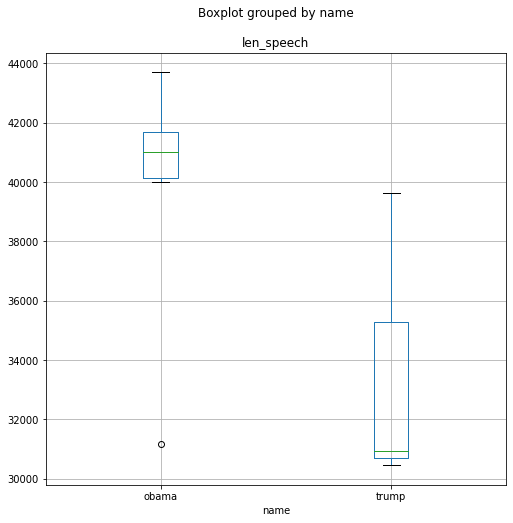

In [65]:
df.boxplot(column='len_speech', by='name', figsize=(8,8))

Unsurprisingly, Obama's speeches are much longer than Trump's! 

### Comparing number of sentences

<AxesSubplot: title={'center': 'num_sentences'}, xlabel='name'>

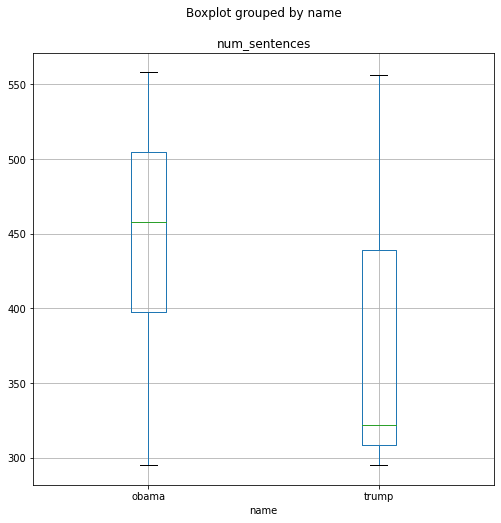

In [66]:
df.boxplot(column='num_sentences', by='name', figsize=(8,8))

Obama also uses more sentences than Trump...

### Comparing average sentence length

<AxesSubplot: title={'center': 'average_sen_length'}, xlabel='name'>

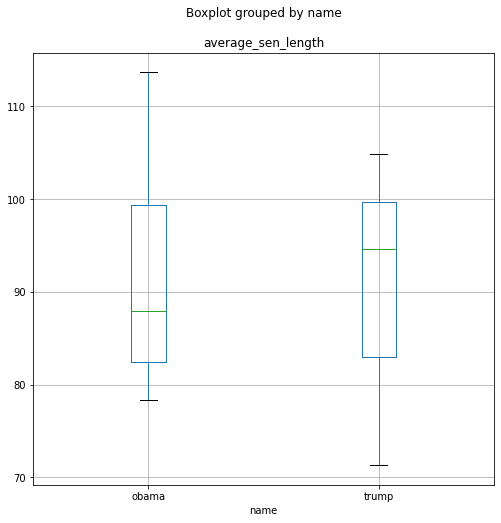

In [67]:
df.boxplot(column='average_sen_length', by='name', figsize=(8,8))

However, it does seem like their sentences have similar interquartile ranges, but I'll calculate their means just to be sure. 

In [68]:
df_mean = df.groupby(['name'])['average_sen_length'].mean()
df_mean

name
obama    91.909316
trump    90.265471
Name: average_sen_length, dtype: float64

There it is -- while Obama's speeches are longer and has more sentences than Trump's speeches, it does seem that on average, their sentences are of the same length.

### Comparing SMOG scores

<AxesSubplot: title={'center': 'SMOG_index'}, xlabel='name'>

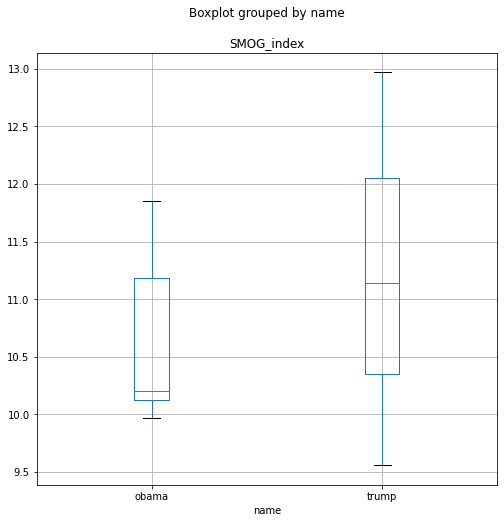

In [70]:
df.boxplot(column='SMOG_index', by='name', figsize=(8,8))

In general, the higher the SMOG score, the higher the education level required to read the text -- and therefore, the harder it is to read. 

According to the boxplots above, it seems like Trump's speeches are harder to read.

### Comparing Flesch Reading Ease scores

<AxesSubplot: title={'center': 'Flesch_score'}, xlabel='name'>

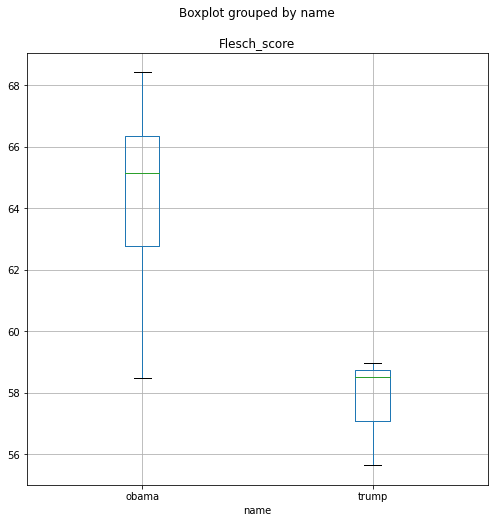

In [71]:
df.boxplot(column='Flesch_score', by='name', figsize=(8,8))

Higher Flesch scores indicate text that is easier to read; lower numbers mark passages that are more difficult to read. Again, it seems like Obama's speeches are easier to read than Trump's. 

These are interesting results -- while it's been known that Obama is a rather verbose speaker, I've always assumed that his speeches were harder to understand. I mean, Obama clearly uses a wide range of vocabulary and has always come across as an eloquent (albeit a little slow...) speaker. What the results indicate is that Trump uses a greater percentage of words with three or more syllables in his speeches, and uses longer sentences and/ or words. 

Another common assumption about Trump is that he tends to appeal to the not-so-educated segments, the middle class voters, as well as Americans in the Rust Belt (commonly termed as "the losers of globalisation") -- and therefore his speeches could be "easier" to read. This obviously says otherwise!

## Noun-to Verb Ratio

Language plays an important role in speeches, and political actors recognise its effects. [Paul Chilton](https://voidnetwork.gr/wp-content/uploads/2016/10/Analysing-political-discourse-Theory-and-Practice-by-Paul-Chilton.pdf) argues that politics is mostly about "the use of language", though not every use of language is political. 

A study conducted by [Idan et al.](https://journals.sagepub.com/doi/abs/10.1177/0956797618772823?journalCode=pssa&) tested the impact of noun form versus verb form on anger and corresponding support for conflictrelated policies in the context of the Israeli-Palestinian conflict. Their study found the following: "results across three studies in the context of the Israeli-Palestinian conflict showed that phrasing support for concessions as well as retaliatory policies toward the out-group (Study 3) in noun form (vs. verb form) reduced levels of anger and, correspondingly, opposition to the former and support for the latter policies". 

In the State of the Union speeches where presidents often lay out their legislative and policy plans for the upcoming year, it would be interesting to see who uses a higher noun-to-verb ratio, and hypothesize a reason for that.

In [72]:
#initiating empty lists to create a new data frame
noun_lst = []
verb_lst = []

# getting the counts for NOUN and VERB from each speech
for index, row in df.iterrows(): 
    lst = nltk.pos_tag(word_tokenize(df['speech'][index]), tagset='universal')
    noun_lst.append(Counter([x[1] for x in lst])['NOUN'])
    verb_lst.append(Counter([x[1] for x in lst])['VERB'])

df['NOUN_count'] = noun_lst
df['VERB_count'] = verb_lst
df['NOUN_to_VERB'] = df['NOUN_count']/df['VERB_count']
df

,filename,name,year,speech,len_speech,sentences,num_sentences,average_sen_length,SMOG_index,Flesch_score,NOUN_count,VERB_count,NOUN_to_VERB
0,all_speeches/obama2016.txt,obama,2016,"Mr. Speaker, Mr. Vice President, Members of Co...",31167,"[Mr, Speaker, Mr, Vice President, Members of...",295,105.650847,10.203070,62.014665,1367,1159,1.179465
1,all_speeches/obama2015.txt,obama,2015,"Mr. Speaker, Mr. Vice President, Members of Co...",40269,"[Mr, Speaker, Mr, Vice President, Members of...",458,87.923581,10.125757,66.451759,1970,1410,1.397163
2,all_speeches/trump2019.txt,trump,2019,"Madam Speaker, Mr. Vice President, Members of ...",30945,"[Madam Speaker, Mr, Vice President, Members o...",295,104.898305,12.968742,55.642559,1609,961,1.674298
3,all_speeches/trump2018.txt,trump,2018,"Mr. Speaker, Mr. Vice President, Members of Co...",30457,"[Mr, Speaker, Mr, Vice President, Members of...",322,94.586957,11.140535,58.501715,1509,1001,1.507493
4,all_speeches/obama2014.txt,obama,2014,"Mr. Speaker, Mr. Vice President, Members of Co...",40009,"[Mr, Speaker, Mr, Vice President, Members of...",352,113.661932,11.855464,58.464553,2048,1418,1.444288
5,all_speeches/obama2010.txt,obama,2010,"Madam Speaker, Vice President Biden, members o...",43698,"[Madam Speaker, Vice President Biden, members ...",558,78.311828,10.125757,65.128535,1980,1601,1.236727
6,all_speeches/trump2020.txt,trump,2020,Thank you very much. Thank you. Thank you v...,39649,"[ Thank you very much, Thank you, Thank yo...",556,71.311151,9.558584,58.962841,2092,1170,1.788034
7,all_speeches/obama2011.txt,obama,2011,"Mr. Speaker, Mr. Vice President, members of Co...",41023,"[Mr, Speaker, Mr, Vice President, members of...",497,82.541247,9.968508,68.414227,2030,1486,1.366083
8,all_speeches/obama2013.txt,obama,2013,"Mr. Speaker, Mr. Vice President, members of Co...",41202,"[Mr, Speaker, Mr, Vice President, members of...",443,93.006772,11.792909,63.555310,2046,1385,1.477256
9,all_speeches/obama2012.txt,obama,2012,"Mr. Speaker, Mr. Vice President, members of C...",42204,"[ Mr, Speaker, Mr, Vice President, members o...",513,82.269006,10.577610,66.274423,2129,1473,1.445350


<AxesSubplot: title={'center': 'NOUN_to_VERB'}, xlabel='name'>

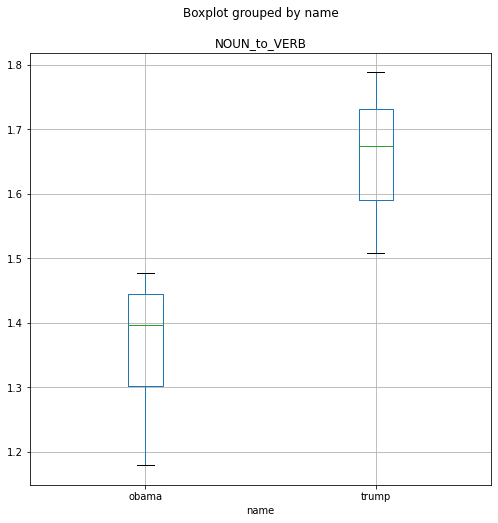

In [73]:
# visually comparing the two politicians' noun-to-verb ratio

df.boxplot(column='NOUN_to_VERB', by='name', figsize=(8,8))

Evidently, Trump uses a higher noun-to-verb ratio than Obama. While it is easy to jump to the conclusion that he uses a more nouns to reduce levels of anger and opposition and increase levels of support for his proposed policies, I hesitate to assume that this is an intended objective. I do think that in general, using verbs instead of nouns add a form of rthetorical imagery to the speeches and hence, makes the audience more aware of the consequences of what you're saying. 

For instance, saying "The assumption that immigrants help the economy warrants further examination." VS "We must examine how immigrants help the economy."

Both are trying to decry the effectiveness of immigration, but the latter makes what the speaker is trying to put more pertinent, more serious, and more consequential. 

Perhaps using a higher noun-to-verb ratio helps Trump to make dismissive claims without being held accountable, because linguistically, it's just harder to hear the impact he's trying to put forth. 

# Sentiment Analysis

Insofar as sentiments can be quite subjective (because people take away different things from speeches), I find it expedient to use NLP to gauge the sentiments of each speech, and how they differ between the two presidents and cross the years. I'll be using the VADER library for this. 

VADER (Valence Aware Dictionary for sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool used for text sentiment analysis and it is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. 

VADER's strengths lie in the fact that it is specifically attuned to sentiments expressed in social media, which means that it's able to take in sentiment-laden slang words (though unlikely to be found in these speeches), increase sentiment intensity for punctuation, and recognise emphasis when ALL CAPS are used. A really cool model that produces easily interpretable results. Results are stored in a dictionary that is straightforward to use. 

## Prepping the Dataframe

In [74]:
#creating a nameyear column
df['nameyear'] = df['filename'].str[13:22]

#sorting the dataframe by year
df = df.sort_values(by=['nameyear']).reset_index()

df

,index,filename,name,year,speech,len_speech,sentences,num_sentences,average_sen_length,SMOG_index,Flesch_score,NOUN_count,VERB_count,NOUN_to_VERB,nameyear
0,5,all_speeches/obama2010.txt,obama,2010,"Madam Speaker, Vice President Biden, members o...",43698,"[Madam Speaker, Vice President Biden, members ...",558,78.311828,10.125757,65.128535,1980,1601,1.236727,obama2010
1,7,all_speeches/obama2011.txt,obama,2011,"Mr. Speaker, Mr. Vice President, members of Co...",41023,"[Mr, Speaker, Mr, Vice President, members of...",497,82.541247,9.968508,68.414227,2030,1486,1.366083,obama2011
2,9,all_speeches/obama2012.txt,obama,2012,"Mr. Speaker, Mr. Vice President, members of C...",42204,"[ Mr, Speaker, Mr, Vice President, members o...",513,82.269006,10.577610,66.274423,2129,1473,1.445350,obama2012
3,8,all_speeches/obama2013.txt,obama,2013,"Mr. Speaker, Mr. Vice President, members of Co...",41202,"[Mr, Speaker, Mr, Vice President, members of...",443,93.006772,11.792909,63.555310,2046,1385,1.477256,obama2013
4,4,all_speeches/obama2014.txt,obama,2014,"Mr. Speaker, Mr. Vice President, Members of Co...",40009,"[Mr, Speaker, Mr, Vice President, Members of...",352,113.661932,11.855464,58.464553,2048,1418,1.444288,obama2014
5,1,all_speeches/obama2015.txt,obama,2015,"Mr. Speaker, Mr. Vice President, Members of Co...",40269,"[Mr, Speaker, Mr, Vice President, Members of...",458,87.923581,10.125757,66.451759,1970,1410,1.397163,obama2015
6,0,all_speeches/obama2016.txt,obama,2016,"Mr. Speaker, Mr. Vice President, Members of Co...",31167,"[Mr, Speaker, Mr, Vice President, Members of...",295,105.650847,10.203070,62.014665,1367,1159,1.179465,obama2016
7,3,all_speeches/trump2018.txt,trump,2018,"Mr. Speaker, Mr. Vice President, Members of Co...",30457,"[Mr, Speaker, Mr, Vice President, Members of...",322,94.586957,11.140535,58.501715,1509,1001,1.507493,trump2018
8,2,all_speeches/trump2019.txt,trump,2019,"Madam Speaker, Mr. Vice President, Members of ...",30945,"[Madam Speaker, Mr, Vice President, Members o...",295,104.898305,12.968742,55.642559,1609,961,1.674298,trump2019
9,6,all_speeches/trump2020.txt,trump,2020,Thank you very much. Thank you. Thank you v...,39649,"[ Thank you very much, Thank you, Thank yo...",556,71.311151,9.558584,58.962841,2092,1170,1.788034,trump2020


## Finding the Sentiment Scores for Each Sentence

Through the VADER library, I'll be obtaining and plotting the positive, negative, neutral, and compound scores of each sentence of each speech. 

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).
positive sentiment : (compound score >= 0.05) 
neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
negative sentiment : (compound score <= -0.05)

In [76]:
# creating a list of processed dataframes

emp_lst = []

for value in df['sentences'].values:
    analyzer = SentimentIntensityAnalyzer() # creating a SentimentIntensityAnalyzer object
    new_df = pd.DataFrame(value, columns=['value'])
    new_df['index'] = new_df.index/new_df.index.stop
    cp_list = []
    pst_list = []
    neg_list = []
    neu_list = []
    for sentence in new_df['value']: # appending the scores of the sentence in the empty list
        cp = analyzer.polarity_scores(sentence)['compound']
        cp_list.append(str(cp))
        pst = analyzer.polarity_scores(sentence)['pos']
        pst_list.append(str(pst))
        neg = analyzer.polarity_scores(sentence)['neg']
        neg_list.append(str(neg))
        neu = analyzer.polarity_scores(sentence)['neu']
        neu_list.append(str(neu))
        
    new_df['compound'] = cp_list
    new_df['positive'] = pst_list
    new_df['negative'] = neg_list
    new_df['neutral'] = neu_list
    
    emp_lst.append(new_df)
    
emp_lst

[                                                 value     index compound  \
 0    Madam Speaker, Vice President Biden, members o...  0.000000      0.0   
 1     For 220 years, our leaders have fulfilled thi...  0.001792   0.4215   
 2     They've done so during periods of prosperity ...  0.003584   0.4215   
 3     And they've done so in the midst of war and d...  0.005376  -0.1779   
 4    \n\nIt's tempting to look back on these moment...  0.007168   0.7184   
 ..                                                 ...       ...      ...   
 553                                     )\n\nThank you  0.991039   0.3612   
 554                                      God bless you  0.992832   0.5994   
 555         And God bless the United States of America  0.994624   0.7717   
 556                                          (Applause  0.996416   0.4215   
 557                                                  )  0.998208      0.0   
 
     positive negative neutral  
 0        0.0      0.0     1.

## Plotting Average Compound Score for Each Speech

I'll be plotting the compound scores first, which is deemed as more reliable because it encompasses the overall sentiment of this corpus. It calculates the sum of all the lexicon ratings, and normalizes them between -1 and 1. 

<BarContainer object of 10 artists>

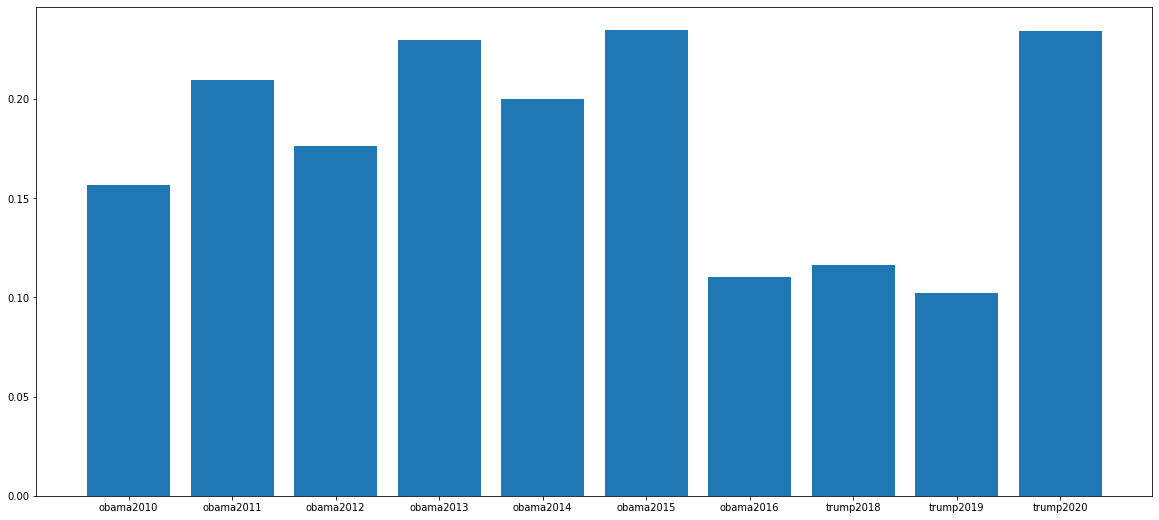

In [77]:
plt.figure(figsize=(20,9))
x = []
cmpd = []

for i in range(10):
    x.append(df['nameyear'][i])
        
for score_df in emp_lst:
    cmpd.append(pd.to_numeric(score_df['compound']).mean())

plt.bar(x,cmpd)

A score of -1 is extremely negative, while a score of 1 is extremely positive. As seen above, the speeches are moderately positive overall (as it should be, for a State of the Union speech). However, we can see differing scores over the years. A point of particular interest is the compound score of Obama's last State of the Union speech -- the lowest compound score of all speeches. In comparison, Trump's last speech scored the highest compound score. Now bear in mind that this was just before COVID-19 struck America in March 2020, and just before American unemployment saw a huge increase (from [281,000 to 3.3 million](https://web.archive.org/web/20200426082647/https://www.theguardian.com/business/2020/mar/26/us-unemployment-rate-coronavirus-business) in a week). The economy in Jan-Feb 2020 was arguably still in a good shape.

## Plotting Average Positive, Negative and Neutral Scores for Each Speech

Because the compound score is a composite score, I'll be plotting the respective positive, negative and neutral scores so I can see the breakdown of each speech.

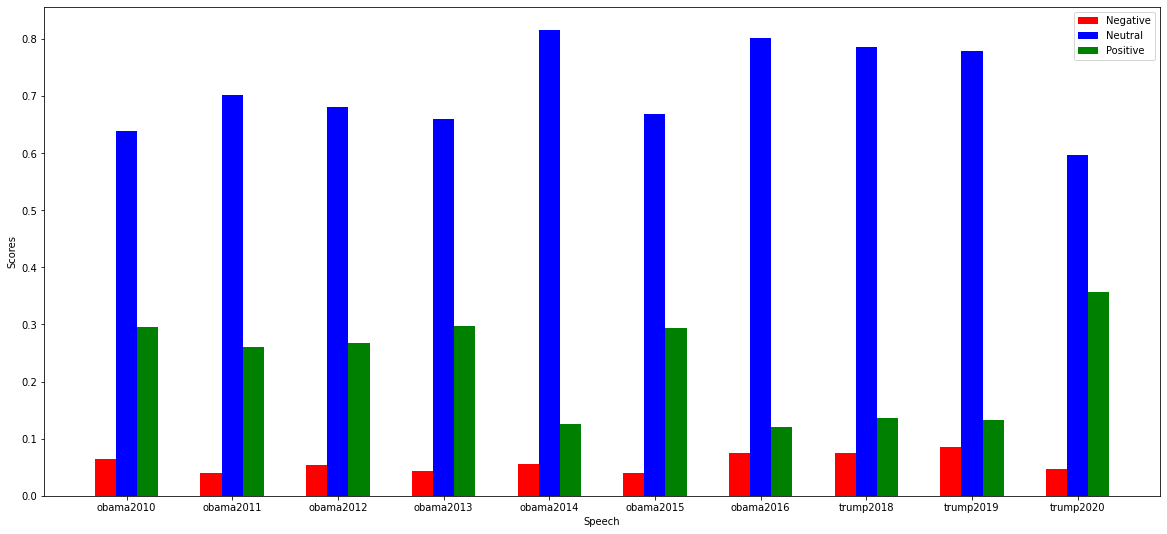

In [78]:
pos = []
neg = []
neu = []
width = 0.2 
r = np.arange(10)

for score_df in emp_lst:
    pos.append(pd.to_numeric(score_df['positive']).mean())
    neg.append(pd.to_numeric(score_df['negative']).mean())
    neu.append(pd.to_numeric(score_df['neutral']).mean())

plt.figure(figsize=(20,9))
bar1 = plt.bar(r, neg, width, color='r')
bar2 = plt.bar(r+width, neu, width, color='b')
bar3 = plt.bar(r+width*2, pos, width, color='g')
plt.xticks(r+width, x)
plt.xlabel("Speech")
plt.ylabel('Scores')
plt.legend( (bar1, bar2, bar3), ('Negative', 'Neutral', 'Positive') )

The Positive, Negative and Neutral scores represent the proportion of text that falls in these categories. As seen above, the neutral segments take the bulk of each speech, but we can see a clear distinction in the positive segments in 2014, 2016, and 2020. 

# Final Thoughts

Speeches are every politician's bread and butter. Politicians not only need to be intelligent and good at policy making, they also need to be charismatic and articulate so that they can persuade the electorate to vote for them or that they're effective leaders. If a political leader does not speak well, it generally will not reflect well on their ability to lead, and can even damage the public's confidence in the governing institutions. Of course, it also means the electorate sometimes misplaces trust in charismatic yet ineffective leaders with pompous speeches. 

Speeches are also important conduits for politicians to brief the public on their legislative, economic and policy agenda -- although with Trump, we saw important policy decisions being announced through informal channels like Twitter. While that has sometimes been criticized, I do think that's the future of politicking and governing because informal channels seem to get the message out faster and to a wider range of people. 

For further analysis, one could consider scraping all speeches from the politicians. Instead of just quantitatively assessing the speeches, it could be useful to carry out topic modeling. I'd imagine the task of matching the frequently occurring topics of the speeches with those on social media could be useful to see how relevant politicians are at addressing the public's concerns. 